# Import libraries

In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from argparse import ArgumentParser

### Tensorflow dependencies ###
import tensorflow as tf

# Create data loader

In [158]:
class DataLoader:
    def __init__(self, data_dir, unlabelled_data_dir, batch_size, u_batch_size, val_ratio):
        '''
            DataLoader constructor

            Arguments :
                data_dir : Data directory with images, masks sub directories
                unlabelled_data_dir : Data directory to images without labels (containing all png files)
                batch_size : Number of instances per batch
                u_batch_size : Unlabelled dataset batch size
                val_ration : Split ratio between test - overall dataset
        '''
        self.data_dir = data_dir 
        self.img_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')

        self.batch_size = batch_size
        self.u_batch_size = u_batch_size
        self.val_ratio = val_ratio

        # Pair the images and the mask
        counter = 0
        self.image_files = []
        self.mask_files = []
        self.unlabelled_img_files = self.__get_img_in_dir(unlabelled_data_dir)
        
        
        if(len(self.unlabelled_img_files) == 0):
            raise Exception('No images in unlabelled image folder')

        for mask in self.__get_img_in_dir(self.mask_dir):
            filename = mask.split('/')[-1]
            
            respective_img = f'{self.img_dir}/{filename}'
            if(respective_img in self.__get_img_in_dir(self.img_dir)):
                self.mask_files.append(mask)
                self.image_files.append(respective_img)
                
        if(len(self.image_files) == 0):
            raise Exception('No images in labelled image folder')
        
        print(f'Number of matching mask-image pairs : {len(self.mask_files)}')

    def __get_img_in_dir(self, directory):
        extensions = ["png", "jpeg", "jpg", "bmp", "tif"]
        imgs = []
        
        for ext in extensions:
            imgs += glob.glob(os.path.join(directory, f'*.{ext}'))

        return imgs
    
    @staticmethod
    def map_fn(img, size=256):
        img = tf.image.resize(img, [size, size])
        img = tf.clip_by_value(img, 0, 255)
        
        mean = tf.math.reduce_mean(img)
        std = tf.math.reduce_std(img)
        img = (img - mean) / std

        return img

    @staticmethod
    def parse_fn(img_file, mask_file):
        img = tf.io.read_file(img_file)
        img = tf.image.decode_png(img, 3)
        img = DataLoader.map_fn(img)

        mask = tf.io.read_file(mask_file)
        mask = tf.image.decode_png(mask, 1)
        mask = tf.cast(mask, dtype=tf.float32)
        mask = tf.image.resize(mask, [256, 256])
        mask = mask / 255.0

        return img, mask
    
    @staticmethod
    def parse_unlabelled_data_fn(img_file):
        # Read image and perform weak and strong augmentation
        img = tf.io.read_file(img_file)
        img = tf.image.decode_png(img, 3)
        
        # Weakly augmented - for now no weakly aug, just leave the original image
        weak_aug = img
        
        # Strongly augmented - random brightness and contrast
        seed = np.random.randint(1000)
        strong_aug = tf.image.random_jpeg_quality(img, 0, 10, seed=seed)
        strong_aug = tf.image.random_brightness(strong_aug, max_delta=0.5, seed=seed)
        strong_aug = tf.image.random_saturation(strong_aug, 0.5, 1.0, seed)
        strong_aug = tf.keras.layers.GaussianNoise(10)(strong_aug)
        
        # Normalize and resize
        weak_aug = DataLoader.map_fn(weak_aug)
        strong_aug = DataLoader.map_fn(strong_aug)

        return weak_aug, strong_aug

    def get_train_val_datasets(self):
        X_train, X_test, Y_train, Y_test = train_test_split(self.image_files, self.mask_files, test_size=self.val_ratio)
        self.train_steps = len(X_train) // self.batch_size + 1
        self.val_steps = len(X_test) // self.batch_size + 1

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = train_dataset.map(DataLoader.parse_fn)
        train_dataset = train_dataset.repeat()
        train_dataset = train_dataset.batch(self.batch_size)
        train_dataset = train_dataset.take(self.train_steps)

        val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
        val_dataset = val_dataset.map(DataLoader.parse_fn)
        val_dataset = val_dataset.repeat()
        val_dataset = val_dataset.batch(self.batch_size)
        val_dataset = val_dataset.take(self.val_steps)

        return train_dataset, val_dataset
    
    def get_unlabelled_dataset(self):
        # Unlabelled dataset will return weakly augmented and strongly augmented images
        u_dataset = tf.data.Dataset.from_tensor_slices(self.unlabelled_img_files)
        u_dataset = u_dataset.map(DataLoader.parse_unlabelled_data_fn)
        u_dataset = u_dataset.repeat()
        u_dataset = u_dataset.batch(self.u_batch_size)
        
        return u_dataset

In [159]:
data_dir = '/home/minhhieu/Desktop/Hieu/LungSegmentation/data/LungSegments'
unlabelled_data_dir = '/home/minhhieu/Desktop/Hieu/LungSegmentation/data/pneumonia/train/NORMAL'
batch_size = 16
u_batch_size = 32
val_ratio = 0.3333
loader = DataLoader(data_dir, unlabelled_data_dir, batch_size, u_batch_size, val_ratio)

Number of matching mask-image pairs : 704


In [160]:
u_dataset = loader.get_unlabelled_dataset()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

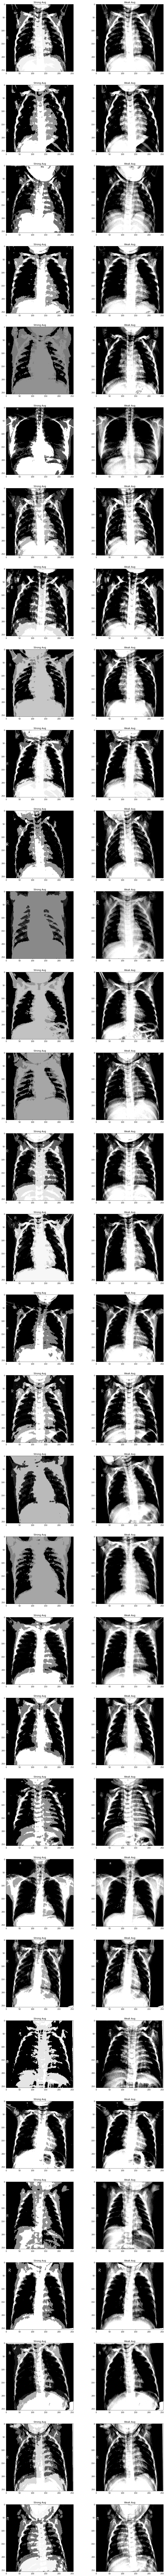

In [184]:
weak_augs, strong_augs = next(iter(u_dataset))
fig, ax = plt.subplots(32, 2, figsize=(16, 256))

for i in range(u_batch_size):
    strong = np.clip(0, 1.0, strong_augs[i].numpy())
    weak = np.clip(0, 1.0, weak_augs[i])
    
    ax[i][0].imshow(strong)
    ax[i][1].imshow(weak)

    ax[i][0].set_title('Strong Aug')
    ax[i][1].set_title('Weak Aug')

plt.show()